### Table of Contents

- 1 [Objective](#1)
- 2 [Dataset overview](#2)
- 3 [Hypothesis testing and vizualisations](#3)
- 4 [Data Cleaning](#4)
- 5 [KNN Classifier](#5)

# **1. Objective** <a class="anchor" id="1"></a>
The main goal of this project is to tackle several important tasks. First, we want to answer questions about the data by conducting **hypothesis testing**. This will help us gain meaningful insights and draw conclusions from the information we have.

Next, we aim to identify any flaws or issues in the data. By carefully examining the dataset, we'll be able to find and address any inconsistencies or errors, ensuring that our analysis is based on reliable and accurate data.

Once the data is cleaned and validated, we'll dive into data analysis. This involves exploring the dataset, looking for patterns, trends, and relationships that can provide valuable insights. By understanding the data better, we can make informed decisions and uncover important findings.

Finally, our objective is to build the best possible prediction model using **KNN Classifier**. 

# **2. Dataset overview** <a class="anchor" id="2"></a>

In [1]:
#Necessary imports
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder

from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [2]:
loan_data=pd.read_csv('/kaggle/input/loan-default-dataset/Loan_Default.csv',index_col='ID')
print(loan_data.shape)
loan_data.head()

(148670, 33)


,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,loan_amount,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
ID,,,,,,,,,,,,,,,,,,,,,
24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,116500,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,206500,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,406500,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,456500,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,696500,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [3]:
#Full parameters list
print(list(loan_data.columns))

#Dropping the year column as it's not representative (all 2019)
loan_data.drop(['year'],axis=1,inplace=True)

['year', 'loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'open_credit', 'business_or_commercial', 'loan_amount', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'term', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'property_value', 'construction_type', 'occupancy_type', 'Secured_by', 'total_units', 'income', 'credit_type', 'Credit_Score', 'co-applicant_credit_type', 'age', 'submission_of_application', 'LTV', 'Region', 'Security_Type', 'Status', 'dtir1']


# **3. Hypothesis testing and visualizations** <a class="anchor" id="3"></a>
Applying a series of test to reinforce the insights given by the visualizations

## Is there a significant difference between the different age groups when it comes to loan status ?

In [4]:
# How many Age groups do we have?
print(loan_data['age'].unique())
print("\n")
#Noticing a nan value, how many null values do we have ?
print("The number of missing 'age' rows: "+str(loan_data['age'].isnull().sum()))

['25-34' '55-64' '35-44' '45-54' '65-74' '>74' '<25' nan]


The number of missing 'age' rows: 200


In [5]:
#Since it represents a small amount of rows compared to the total, I am dropping these rows
loan_data_fullage=loan_data.dropna(subset=["age"])
print(loan_data_fullage.shape)

(148470, 32)


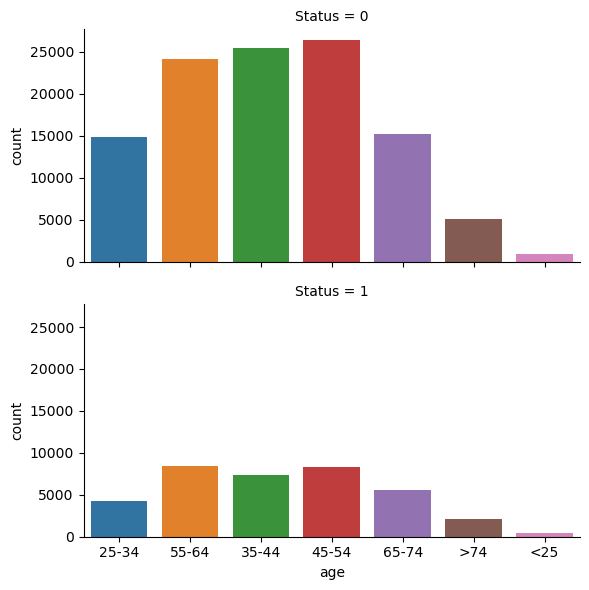

In [6]:
sns.catplot(x='age', row = 'Status',
            kind='count', data=loan_data_fullage,
            height = 3, aspect = 2)
plt.show()

**Observation:** The graph shows that loan status (fulfilled or unfulfilled) is not the same across all age groups. There are some age groups where loan fulfillment is more common, and others where loan non-fulfillment is more common. This means that age might be an important factor in whether a loan is fulfilled or not, and we should look into it more to find out why.
In order to determine if there is a statistically significant difference in loan fulfillment between these groups, we should conduct a **Chi2 test** that accounts for the differences in sample size

In [7]:
# Applying The Chi2 squared test 

The Chi2 squared test can be useful for testing the association between two categorical variables

**H0**: There is no significant difference between the different age groups when it comes to loan status

**H1**: There is a significant difference between the different age groups when it comes to loan status

Chosen **Alpha Value** : 0.05

In [8]:
#contingency table
cont_table  = pd.crosstab(loan_data_fullage['age'], loan_data_fullage['Status'])
cont_table

Status,0,1
age,,
25-34,14894,4248
35-44,25509,7309
45-54,26371,8349
55-64,24112,8422
65-74,15173,5571
<25,950,387
>74,5022,2153


In [9]:
#Computing P value 
_,p,_,expected=scipy.stats.chi2_contingency(cont_table, correction = True)
print("The obtained P-Value is: "+str(p))
print("\n")
print("The expected frequencies are: ")
expected_df=pd.DataFrame(expected)
expected_df.columns=cont_table.columns
expected_df.index=cont_table.index
expected_df

The obtained P-Value is: 8.442234122939632e-78


The expected frequencies are: 


Status,0,1
age,,
25-34,14443.977921,4698.022079
35-44,24763.476514,8054.523486
45-54,26198.668553,8521.331447
55-64,24549.178649,7984.821351
65-74,15652.798976,5091.201024
<25,1008.860019,328.139981
>74,5414.039368,1760.960632


**Conclusion:** Since the P-value is largely inferior to the signficance level (alpha Value) that we have chosen, then we reject the Null hypothesis as there is enough proof that there is an association between the AGE and the loan STATUS.

# Is there a significant difference in loan status based on gender ? 

In [10]:
loan_data.Gender.value_counts()
#To answer this question, I am only going to use the "Male" and "Female" genders , as joint being them combined and "Sex Not Available" non-informative

Male                 42346
Joint                41399
Sex Not Available    37659
Female               27266
Name: Gender, dtype: int64

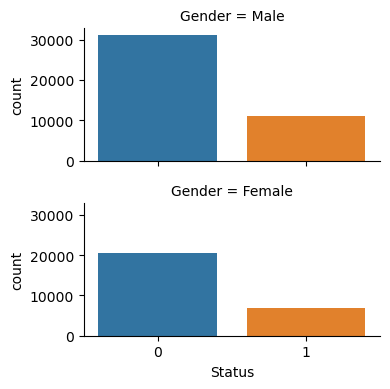

In [11]:
loan_per_gender=loan_data[(loan_data.Gender=="Female") | (loan_data.Gender=="Male")]
sns.catplot(x='Status', row = 'Gender',
            kind='count', data=loan_per_gender,
            height = 2, aspect = 2)
plt.show()

We can't really tell from the graph if there is a statistical difference between the two genders in loan fulfillment as we don't have the same number of samples for each gender. We can investigate the association between gender and loan status using the same test.

In [12]:
# Applying The Chi2 squared test 

**H0**: There is no significant difference in loan status based on gender 

**H1**: There is a significant difference in loan status based on gender 

Chosen Significance Level : 0.05

In [13]:
cont_table2=pd.crosstab(loan_per_gender.Gender,loan_per_gender.Status)
cont_table2

Status,0,1
Gender,,
Female,20418,6848
Male,31255,11091


In [14]:
_,p2,_,expected2=scipy.stats.chi2_contingency(cont_table2, correction = True)
expected2=pd.DataFrame(expected2,index=cont_table2.index)
expected2.columns=cont_table2.columns
print("The P_value obtained from this test is: "+str(p2))
expected2

The P_value obtained from this test is: 0.0015827031471534522


Status,0,1
Gender,,
Female,20239.556657,7026.443343
Male,31433.443343,10912.556657


**Conclusion:** Since the P-value is less than the signficance level (alpha Value) that we have chosen, then we reject the Null hypothesis as there is enough proof that there is an association between the GENDER and the loan STATUS.

# What it is the probability of getting an LTV value (Loan-to-Value) ratio more than 100% for non-remboursé loans ? 
How frequently does a client asks for an amount of money greater than the property value ?

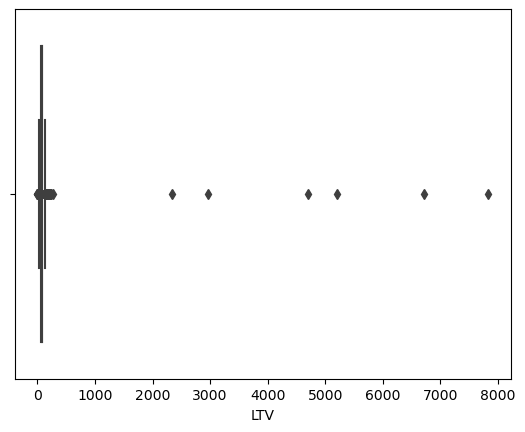

In [15]:
sns.boxplot(x="LTV", data=loan_data)
plt.show()
#Well, there is a problem

The main cause of the problem can be attributed to outliers. Since the Loan-to-Value (LTV) ratio represents a percentage, the values should ideally fall between 0 and 1. The LTV is calculated by dividing the loan amount by the property value. However, it is possible for the LTV to exceed 1 slightly if the loan amount surpasses the property value.


In [16]:
# one of the outliers
print(loan_data.LTV.max())

loan_data[['property_value','loan_amount','LTV']][loan_data.LTV>1000]
#1000 as a test value

7831.25


,property_value,loan_amount,LTV
ID,,,
41841,8000.0,626500,7831.25
71177,8000.0,236500,2956.25
72697,8000.0,416500,5206.25
80176,8000.0,536500,6706.25
90128,8000.0,376500,4706.25
148233,8000.0,186500,2331.25


Bingo! The value 8000 is systematically repeated when the LTV value is odd, suggesting that the missing values in the "property_value" column have been inputted intentionally. In other words, 8000 represents an initially missing value.

In [17]:
odd_df=loan_data[['property_value','loan_amount','LTV']][loan_data.property_value==8000.0]
odd_df

,property_value,loan_amount,LTV
ID,,,
41841,8000.0,626500,7831.25
71177,8000.0,236500,2956.25
72697,8000.0,416500,5206.25
80176,8000.0,536500,6706.25
90128,8000.0,376500,4706.25
148233,8000.0,186500,2331.25


To address this issue, we have a couple of options. One approach is to replace these missing property values with an **imputation method** of our choice and then recalculate the LTV using the imputed values. Alternatively, we can choose to drop these rows entirely, considering that they constitute a small percentage of our overall data.

Given that the affected rows represent a minimal portion of the dataset, it may be more prudent to simply **drop** them from further analysis (this can be considered as part of the [data cleaning](#4) part).

In [18]:
odd_indexes=odd_df.index
odd_indexes

Int64Index([41841, 71177, 72697, 80176, 90128, 148233], dtype='int64', name='ID')

In [19]:
#Deleting the rows
odd_indexes=odd_df.index
print(loan_data.shape)
odd_indexes=list(odd_df.index)
loan_data.drop(index=odd_indexes,inplace=True)
print(loan_data.shape)



(148670, 32)
(148664, 32)


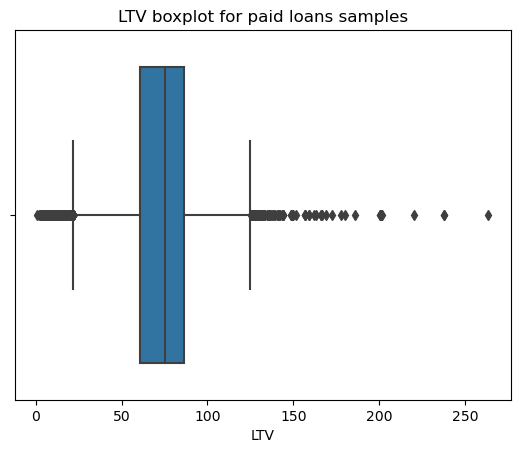

In [20]:
sns.boxplot(x="LTV", data=loan_data)
plt.title("LTV boxplot for paid loans samples")
plt.show()

In [21]:
#Computing the probability
loan_mean = round(loan_data['LTV'][loan_data.Status==0].mean(), 3)
loan_sd = round(loan_data['LTV'][loan_data.Status==0].std(), 3)

prob0 = scipy.stats.norm.cdf((100 - loan_mean)/loan_sd)
prob=1-prob0
print(prob)

0.06377589719967247


**Conclusion:** Given that the probability of getting an LTV ratio more than 100% is low (for non fulfilled cases), even if it represents a high-risk authorization, it would be advisable for the loan lender to keep offering this kind of service

# **4. Data Cleaning** <a class="anchor" id="4"></a>

In [22]:
loan_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
loan_amount,148664.0,331115.105204,183909.937139,16500.000000,196500.00000,296500.00000,436500.000000,3.576500e+06
rate_of_interest,112226.0,4.045488,0.561400,0.000000,3.62500,3.99000,4.375000,8.000000e+00
Interest_rate_spread,112026.0,0.441634,0.513040,-3.638000,0.07600,0.39030,0.775375,3.357000e+00
Upfront_charges,109023.0,3225.144031,3251.122700,0.000000,581.86000,2596.76000,4812.500000,6.000000e+04
term,148623.0,335.135578,58.410049,96.000000,360.00000,360.00000,360.000000,3.600000e+02
property_value,133566.0,497915.472500,359928.422921,18000.000000,268000.00000,418000.00000,628000.000000,1.650800e+07
income,139520.0,6957.338876,6496.586382,0.000000,3720.00000,5760.00000,8520.000000,5.785800e+05
Credit_Score,148664.0,699.790945,115.875971,500.000000,599.00000,699.00000,800.000000,9.000000e+02
LTV,133566.0,72.527082,18.942534,0.967478,60.47486,75.13587,86.184211,2.635417e+02
Status,148664.0,0.246448,0.430944,0.000000,0.00000,0.00000,0.000000,1.000000e+00


In [23]:
# Visualization of continious variables distribution
continious_cols=[col for col in loan_data.columns if loan_data[col].dtype == "float64"]
print(continious_cols)
loan_data[continious_cols]

['rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'term', 'property_value', 'income', 'LTV', 'dtir1']


,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,LTV,dtir1
ID,,,,,,,,
24890,NaN,NaN,NaN,360.0,118000.0,1740.0,98.728814,45.0
24891,NaN,NaN,NaN,360.0,NaN,4980.0,NaN,NaN
24892,4.560,0.2000,595.00,360.0,508000.0,9480.0,80.019685,46.0
24893,4.250,0.6810,NaN,360.0,658000.0,11880.0,69.376900,42.0
24894,4.000,0.3042,0.00,360.0,758000.0,10440.0,91.886544,39.0
...,...,...,...,...,...,...,...,...
173555,3.125,0.2571,9960.00,180.0,608000.0,7860.0,71.792763,48.0
173556,5.190,0.8544,0.00,360.0,788000.0,7140.0,74.428934,15.0
173557,3.125,0.0816,1226.64,180.0,728000.0,6900.0,61.332418,49.0


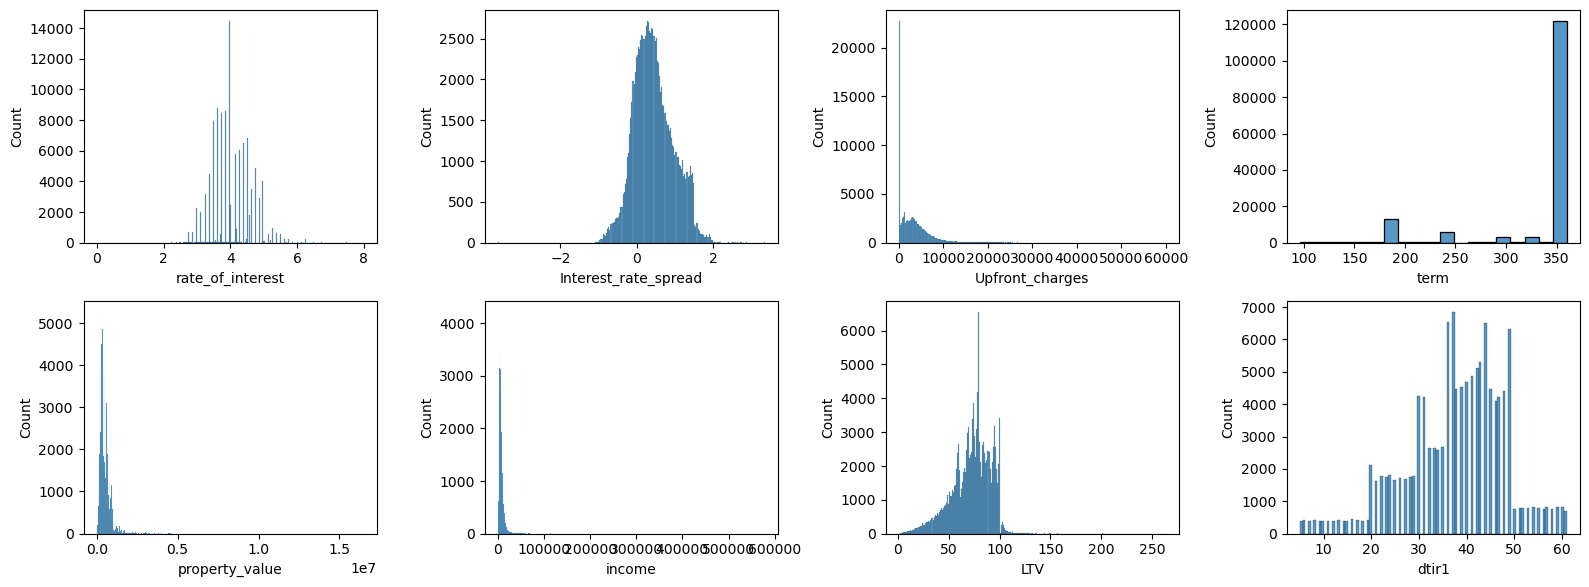

In [24]:
indexes=[]
for i in range(2):
    for j in range(4):
        indexes.append([i,j])
# Create a figure with a single row and multiple columns
fig, axes = plt.subplots(ncols=4,nrows=2,figsize=(16, 6))

for l in range(len(continious_cols)):
    sns.histplot(data=loan_data,x=str(continious_cols[l]),ax=axes[indexes[l][0],indexes[l][1]])

plt.tight_layout()
plt.show()


**Observation:** We have observed the presence of numerous outliers in the dataset. **Scaling** these numerical values will help reduce the impact of these outliers on the KNN model's performance. We will also address missing values through imputation using the **"median"** strategy for continuous variables and the **"most frequent"** strategy for discrete variables. Since the term variable is a categorical variable, it will be excluded from the list of continuous variables.

In [25]:
y=loan_data['Status']
X=loan_data.drop(['Status'],axis=1)
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42)

In [26]:
#REPLACING MISSING NUMERICAL VALUES WITH THEIR MEDIAN
num_cols=[col for col in X_train.columns if X_train[col].dtype in ["float64","int8","int64"]]
num_cols.remove('term')
my_imputer = SimpleImputer(strategy="median")
train_imputed_loan_data_num = pd.DataFrame(my_imputer.fit_transform(X_train[num_cols]))
test_imputed_loan_data_num = pd.DataFrame(my_imputer.transform(X_test[num_cols]))



#Checking presence of null values
print(train_imputed_loan_data_num.isnull().any().any())
print(test_imputed_loan_data_num.isnull().any().any())

False
False


In [27]:
my_imputer2 = SimpleImputer(strategy="most_frequent")
train_imputed_term=pd.DataFrame(my_imputer2.fit_transform(np.array(X_train['term']).reshape(-1,1)))
test_imputed_term=pd.DataFrame(my_imputer2.transform(np.array(X_test['term']).reshape(-1,1)))

train_imputed_term.columns=['term']
test_imputed_term.columns=['term']

print(pd.DataFrame(train_imputed_term).isnull().any())
print(pd.DataFrame(test_imputed_term).isnull().any())

term    False
dtype: bool
term    False
dtype: bool


In [28]:
#REPLACING MISSING CATEGORICAL VALUES WITH THE MOST FREQUENT VALUE
cat_cols=[col for col in loan_data.columns if loan_data[col].dtype =="object"]

train_imputed_loan_data_cat = pd.DataFrame(my_imputer2.fit_transform(X_train[cat_cols]))
test_imputed_loan_data_cat = pd.DataFrame(my_imputer2.transform(X_test[cat_cols]))

train_imputed_loan_data_cat.columns=cat_cols
test_imputed_loan_data_cat.columns=cat_cols

train_imputed_loan_data_cat=train_imputed_loan_data_cat.join(train_imputed_term)
test_imputed_loan_data_cat=test_imputed_loan_data_cat.join(test_imputed_term)


In [29]:
loan_data[loan_data['Gender']=='Sex Not Available'].shape
#Too many rows with 'Sex Not Available' as 'Gender' value,37659 rows, which representes a lot of data.
#filling these "empty" cells with the most frequent value can lead the model to severe mistakes, so I leave it as it is

(37659, 32)

When encoding categorical features, we have two options: **ordinal** encoding and one-hot encoding. The choice between them depends on the nature of the feature. If a feature does not possess any inherent order or hierarchy among its categories, we should choose one-hot encoding. On the other hand, if a feature exhibits a meaningful order or hierarchy among its categories, we should opt for ordinal encoding.

In [30]:
#Separating categorical features
one_hot_encoding_features = [
    'Gender',
    'loan_type',
    'loan_purpose',
    'business_or_commercial',
    'construction_type',
    'occupancy_type',
    'Secured_by',
    'credit_type',
    'co-applicant_credit_type',
    'submission_of_application',
    'Region',
    'Security_Type'
]

ordinal_encoding_features = [
    'loan_limit',
    'Credit_Worthiness',
    'open_credit',
    'Neg_ammortization',
    'interest_only',
    'lump_sum_payment',
    'total_units',
    'age',
    'term'
]


#One-hot Encoding
OHtrain_imputed_loan_data_cat=pd.get_dummies(train_imputed_loan_data_cat[one_hot_encoding_features])
OHtest_imputed_loan_data_cat=pd.get_dummies(test_imputed_loan_data_cat[one_hot_encoding_features])

#Ordinal
OREncoder=OrdinalEncoder()
ORtrain_imputed_loan_data_cat=pd.DataFrame(OREncoder.fit_transform(train_imputed_loan_data_cat[ordinal_encoding_features]))
ORtest_imputed_loan_data_cat=pd.DataFrame(OREncoder.transform(test_imputed_loan_data_cat[ordinal_encoding_features]))

ORtrain_imputed_loan_data_cat.columns=ordinal_encoding_features
ORtest_imputed_loan_data_cat.columns=ordinal_encoding_features

train_cat=ORtrain_imputed_loan_data_cat.join(OHtrain_imputed_loan_data_cat)
test_cat=ORtest_imputed_loan_data_cat.join(OHtest_imputed_loan_data_cat)

In [31]:
train_imputed_loan_data_num.head()

,0,1,2,3,4,5,6,7,8
0,196500.0,3.250,-0.3321,1770.18,268000.0,5760.0,799.0,73.320896,39.0
1,436500.0,4.125,0.3790,1789.06,558000.0,6420.0,814.0,78.225806,38.0
2,476500.0,3.990,0.3914,2600.00,418000.0,0.0,807.0,75.135870,39.0
3,266500.0,4.875,1.2034,2255.00,338000.0,4860.0,802.0,78.846154,45.0
4,516500.0,3.990,-0.3116,0.00,618000.0,7320.0,622.0,83.576052,49.0


In [32]:
OHtrain_imputed_loan_data_cat.head()

,Gender_Female,Gender_Joint,Gender_Male,Gender_Sex Not Available,loan_type_type1,loan_type_type2,loan_type_type3,loan_purpose_p1,loan_purpose_p2,loan_purpose_p3,...,co-applicant_credit_type_CIB,co-applicant_credit_type_EXP,submission_of_application_not_inst,submission_of_application_to_inst,Region_North,Region_North-East,Region_central,Region_south,Security_Type_Indriect,Security_Type_direct
0,0,1,0,0,0,0,1,0,0,0,...,0,1,0,1,1,0,0,0,0,1
1,0,0,0,1,1,0,0,0,0,1,...,1,0,0,1,0,0,0,1,0,1
2,0,1,0,0,0,1,0,0,0,0,...,0,1,1,0,1,0,0,0,0,1
3,1,0,0,0,1,0,0,0,0,1,...,0,1,0,1,1,0,0,0,0,1
4,0,1,0,0,0,0,1,1,0,0,...,0,1,1,0,1,0,0,0,0,1


In [33]:
scaler = StandardScaler()
train_imputed_loan_data_num=pd.DataFrame(scaler.fit_transform(train_imputed_loan_data_num))
test_imputed_loan_data_num=pd.DataFrame(scaler.transform(test_imputed_loan_data_num))


train_imputed_loan_data_num.columns=num_cols
test_imputed_loan_data_num.columns=num_cols


In [34]:
# final train/test sets
train_data=train_imputed_loan_data_num.join(train_cat)
test_data=test_imputed_loan_data_num.join(test_cat)

In [35]:
y_train.value_counts()

0    83975
1    27523
Name: Status, dtype: int64

In [36]:
ROS=RandomOverSampler(sampling_strategy="not majority")
X_train,Y_train=ROS.fit_resample(train_data,y_train)
Y_train.value_counts()

0    83975
1    83975
Name: Status, dtype: int64

# **5. KNN Classifier** <a class="anchor" id="5"></a>

In [37]:
from sklearn.neighbors import KNeighborsClassifier
KnnPred=KNeighborsClassifier()
KnnPred.fit(X_train,Y_train)
y_preds=KnnPred.predict(test_data)
y_preds

array([1, 1, 1, ..., 1, 0, 0])

In [38]:
#Keeping the default parameters
KnnPred.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [39]:
print(accuracy_score(y_test,y_preds))
# Cross Val
scores = cross_val_score(KnnPred, X_train, Y_train, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())


0.8852445783780875
Mean cross-validation score: 0.92


**Conclusion:** The model produced satisfactory results, and the preprocessing steps implemented earlier have undoubtedly contributed to its success. I made modifications based on my understanding of the data's characteristics and requirements. However, I remain open to further suggestions or improvements for handling the data, which can be invaluable for future iterations of this notebook. If you have any additional proposals or recommendations on how to enhance the data processing and modeling pipeline, please share them in the comments, and I will give them due consideration. Continuous refinement is key to optimizing the performance of the model and achieving even better results. 